# Naiwny klasyfikator bayesowski

Celem ćwiczenia jest zapoznanie się z technikami konstrukcji naiwnego klasywikatora bayesowskiego. 

Ćwiczenie oparte jest o artykuł z [linku](https://www.kaggle.com/prashant111/naive-bayes-classifier-in-python/notebook)

In [56]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score

Na początku proszę wczytać plik __data.csv__ używając jako separatora ',':

In [2]:
df = pd.read_csv("data.csv")
print(f"Wymiar danych: {df.shape}")
df.head()

Wymiar danych: (32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Następnie sprawdź które z kolumn zawierają dane tekstowe lub liczbowe. W tym celu sprawdź wartość  argumentu *dtype* z odpowiednim warunkiem:

In [3]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

In [4]:
categorical = [var for var in df.columns if df[var].dtype == 'O']
print(f"Zmienne kategorialne:\n{categorical}")
print()
numerical = [var for var in df.columns if df[var].dtype != 'O']
print(f"Zmienne liczbowe:\n{numerical}")

Zmienne kategorialne:
['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']

Zmienne liczbowe:
['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


In [5]:
df[categorical].head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [6]:
df[numerical].head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


Sprawdź czy dane w kolumnach nie zawierają braków a jeżeli tak uzupełnij je według znanych Ci metod:

In [7]:
df[categorical].isnull().sum()

workclass         0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
native_country    0
income            0
dtype: int64

Nie ma brakujących wartości podanych jawnie, czyli jako NaN. Przyjrzyjmy się głębiej.

In [8]:
for var in categorical:
    print(df[var].value_counts())

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital_status, dtype: int64
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial

Zmienne "workclass", "occupation" i "native_country" zawierają brakujące wartości podane niejawnie - w postaci znaków zapytania "?". Dlatego metoda isnull() ich nie wykryła. Zastąpmy "?" poprzez NaN.

In [9]:
df["workclass"].replace(" ?", np.NaN, inplace=True)
df.workclass.value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [10]:
df["occupation"].replace(" ?", np.NaN, inplace=True)
df.occupation.value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

In [11]:
df["native_country"].replace(" ?", np.NaN, inplace=True)
df.native_country.value_counts()

 United-States                 29170
 Mexico                          643
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 France                           29
 

In [12]:
df[categorical].isnull().sum()

workclass         1836
education            0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
native_country     583
income               0
dtype: int64

In [13]:
for var in categorical:
    print(f"Moc zbioru {var} to: {len(df[var].unique())}")

Moc zbioru workclass to: 9
Moc zbioru education to: 16
Moc zbioru marital_status to: 7
Moc zbioru occupation to: 15
Moc zbioru relationship to: 6
Moc zbioru race to: 5
Moc zbioru sex to: 2
Moc zbioru native_country to: 42
Moc zbioru income to: 2


Zbiór native_country zawiera stosunkowo elementów w porównaniu do innych. Po uczeniu i testowaniu sprawdzimy to ponownie.

In [14]:
df[numerical].isnull().sum()

age               0
fnlwgt            0
education_num     0
capital_gain      0
capital_loss      0
hours_per_week    0
dtype: int64

Zmienne liczbowe nie zawierają brakujących wartości.

Na przygotowanych danych przeprowadź proces tworzenia zbiorów uczących i testowych, tak by klasyfikator rozpoznawał do której z grup w kolumnie 'income' należy opisywana osoba


In [15]:
X = df.drop(["income"], axis=1)
y = df["income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(f"Wymiary zbioru uczącego: {X_train.shape}")
print(f"Wymiary zbioru testowego: {X_test.shape}")

Wymiary zbioru uczącego: (22792, 14)
Wymiary zbioru testowego: (9769, 14)


Uzupełniamy brakujące wartości tymi najczęściej występującymi - wartości modalne.

In [16]:
workclass_mode = X_train["workclass"].mode()[0]
occupation_mode = X_train["occupation"].mode()[0]
native_country_mode = X_train["native_country"].mode()[0]

for df_X in [X_train, X_test]:
    df_X["workclass"].fillna(workclass_mode, inplace=True)
    df_X["occupation"].fillna(occupation_mode, inplace=True)
    df_X["native_country"].fillna(native_country_mode, inplace=True)    

In [17]:
X_train.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
dtype: int64

In [18]:
X_test.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
dtype: int64

Przy pomocy biblioteki [category_encoders](https://contrib.scikit-learn.org/category_encoders/) przeprowadź proces kodowania zmiennych tektowych z pozostałych kategorii na wartości liczbowe:

In [19]:
encoder = ce.OneHotEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
print(f"Wymiar zbioru uczącego: {X_train.shape}")
print(f"Wymiar zbioru testowego: {X_test.shape}")

/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Wymiar zbioru uczącego: (22792, 105)
Wymiar zbioru testowego: (9769, 105)


In [20]:
X_train.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,native_country_32,native_country_33,native_country_34,native_country_35,native_country_36,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41
32098,45,1,0,0,0,0,0,0,0,170871,...,0,0,0,0,0,0,0,0,0,0
25206,47,0,1,0,0,0,0,0,0,108890,...,0,0,0,0,0,0,0,0,0,0
23491,48,1,0,0,0,0,0,0,0,187505,...,0,0,0,0,0,0,0,0,0,0
12367,29,1,0,0,0,0,0,0,0,145592,...,0,0,0,0,0,0,0,0,0,0
7054,23,1,0,0,0,0,0,0,0,203003,...,0,0,0,0,0,0,0,0,0,0


In [21]:
X_test.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,native_country_32,native_country_33,native_country_34,native_country_35,native_country_36,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41
22278,27,1,0,0,0,0,0,0,0,177119,...,0,0,0,0,0,0,0,0,0,0
8950,27,1,0,0,0,0,0,0,0,216481,...,0,0,0,0,0,0,0,0,0,0
7838,25,1,0,0,0,0,0,0,0,256263,...,0,0,0,0,0,0,0,0,0,0
16505,46,1,0,0,0,0,0,0,0,147640,...,0,0,0,0,0,0,0,0,0,0
19140,45,1,0,0,0,0,0,0,0,172822,...,0,0,0,0,0,0,0,0,0,0


Warto jeszcze przeprowadzić skalowanie.

In [22]:
cols = X_train.columns
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [23]:
X_train.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,native_country_32,native_country_33,native_country_34,native_country_35,native_country_36,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41
0,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.058906,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.50,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.578076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.270650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.210240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
X_test.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,native_country_32,native_country_33,native_country_34,native_country_35,native_country_36,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41
0,-0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.006571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.656361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.253496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.042564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Używając [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) przeprowadź klasyfikację daych ze zbiorów testowych i treningowych. Podaj dokładnosć modelu i macierz błędu wraz z jej wykresem i interpretacją.

In [29]:
# Model
gnb = GaussianNB()

# Dopasowanie
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(f"Predykcje:\n{y_pred}")

Predykcje:
[' <=50K' ' <=50K' ' >50K' ... ' >50K' ' <=50K' ' <=50K']


/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [32]:
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred)}")
print(f"Średnia dokładność zbioru uczącego {gnb.score(X_train, y_train)}")
print(f"Średnia dokładność zbioru testowego {gnb.score(X_test, y_test)}")

Dokładność modelu: 0.8082710615211383
Średnia dokładność zbioru uczącego 0.8067304317304317


/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


Średnia dokładność zbioru testowego 0.8082710615211383


Średnie dokładności są porównywalne, co dobrze świadczy o modelu.

In [34]:
#Nullaccuracy
y_test.value_counts()

 <=50K    7407
 >50K     2362
Name: income, dtype: int64

In [35]:
null_accuracy = (7407 / (7407 + 2362))
print(f"Null accuracy score: {null_accuracy}")

Null accuracy score: 0.7582147609786057


Dokładność modelu jest większa od null accuracy, co bardzo dobrze świadczy o modelu.

In [38]:
cm = confusion_matrix(y_test, y_pred)
print(f"Tablica pomyłek:\n{cm}\n")
print(f"Liczba klasyfikacji prawdziwie pozytywnych (TP): {cm[0, 0]}")
print(f"Liczba klasyfikacji prawdziwie negatywnych (TN): {cm[1, 1]}")
print(f"Liczba klasyfikacji fałszywie pozytywnych (FP): {cm[0, 1]}")
print(f"Liczba klasyfikacji fałszywie negatywnych (FN): {cm[1, 0]}")
print()
print(f"Liczba poprawnych predykcji: {cm[0, 0] + cm[1, 1]}")
print(f"Liczba niepoprawnych predykcji: {cm[0, 1] + cm[1, 0]}")

Tablica pomyłek:
[[5999 1408]
 [ 465 1897]]

Liczba klasyfikacji prawdziwie pozytywnych (TP): 5999
Liczba klasyfikacji prawdziwie negatywnych (TN): 1897
Liczba klasyfikacji fałszywie pozytywnych (FP): 1408
Liczba klasyfikacji fałszywie negatywnych (FN): 465

Liczba poprawnych predykcji: 7896
Liczba niepoprawnych predykcji: 1873


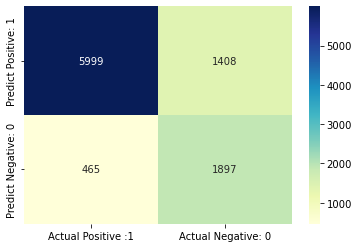

In [42]:
cm_matrix = pd.DataFrame(data=cm, columns=["Actual Positive :1", "Actual Negative: 0"], 
                                 index=["Predict Positive: 1", "Predict Negative: 0"])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.93      0.81      0.86      7407
        >50K       0.57      0.80      0.67      2362

    accuracy                           0.81      9769
   macro avg       0.75      0.81      0.77      9769
weighted avg       0.84      0.81      0.82      9769



In [45]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))
precision = TP / float(TP + FP)


print('Precision : {0:0.4f}'.format(precision))
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {0:0.4f}'.format(recall))
true_positive_rate = TP / float(TP + FN)


print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))
false_positive_rate = FP / float(FP + TN)


print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

specificity = TN / (TN + FP)

print('Specificity : {0:0.4f}'.format(specificity))


Classification accuracy : 0.8083
Classification error : 0.1917
Precision : 0.8099
Recall or Sensitivity : 0.9281
True Positive Rate : 0.9281
False Positive Rate : 0.4260
Specificity : 0.5740


In [46]:
y_pred_prob = gnb.predict_proba(X_test)[0:10]
y_pred_prob

/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


array([[9.99999426e-01, 5.74152436e-07],
       [9.99687907e-01, 3.12093456e-04],
       [1.54405602e-01, 8.45594398e-01],
       [1.73624321e-04, 9.99826376e-01],
       [8.20121011e-09, 9.99999992e-01],
       [8.76844580e-01, 1.23155420e-01],
       [9.99999927e-01, 7.32876705e-08],
       [9.99993460e-01, 6.53998797e-06],
       [9.87738143e-01, 1.22618575e-02],
       [9.99999996e-01, 4.01886317e-09]])

In [47]:
y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Prob of - <=50K', 'Prob of - >50K'])

y_pred_prob_df


,Prob of - <=50K,Prob of - >50K
0,9.999994e-01,5.741524e-07
1,9.996879e-01,3.120935e-04
2,1.544056e-01,8.455944e-01
3,1.736243e-04,9.998264e-01
4,8.201210e-09,1.000000e+00
5,8.768446e-01,1.231554e-01
6,9.999999e-01,7.328767e-08
7,9.999935e-01,6.539988e-06
8,9.877381e-01,1.226186e-02
9,1.000000e+00,4.018863e-09


/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


Text(0, 0.5, 'Frequency')

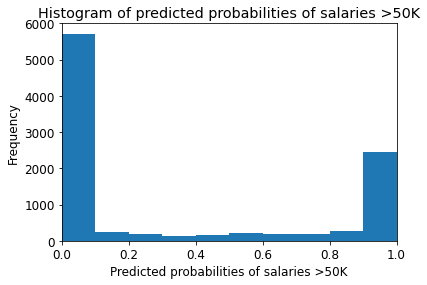

In [48]:
y_pred1 = gnb.predict_proba(X_test)[:, 1]
# adjust the font size 
plt.rcParams['font.size'] = 12


# plot histogram with 10 bins
plt.hist(y_pred1, bins = 10)


# set the title of predicted probabilities
plt.title('Histogram of predicted probabilities of salaries >50K')


# set the x-axis limit
plt.xlim(0,1)


# set the title
plt.xlabel('Predicted probabilities of salaries >50K')
plt.ylabel('Frequency')


    We can see that the above histogram is highly positive skewed.

    The first column tell us that there are approximately 5700 observations with probability between 0.0 and 0.1 whose salary is <=50K.

    There are relatively small number of observations with probability > 0.5.

    So, these small number of observations predict that the salaries will be >50K.

    Majority of observations predcit that the salaries will be <=50K.


/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


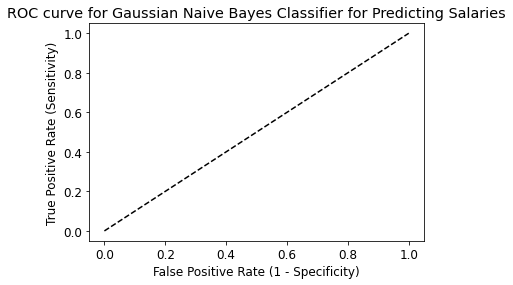

In [50]:


fpr, tpr, thresholds = roc_curve(y_test, y_pred1, pos_label = '>50K')

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Gaussian Naive Bayes Classifier for Predicting Salaries')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

ROC AUC stands for Receiver Operating Characteristic - Area Under Curve. It is a technique to compare classifier performance. In this technique, we measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [52]:
ROC_AUC = roc_auc_score(y_test, y_pred1)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.8941




    ROC AUC is a single number summary of classifier performance. The higher the value, the better the classifier.

    ROC AUC of our model approaches towards 1. So, we can conclude that our classifier does a good job in predicting whether it will rain tomorrow or not.


In [59]:


Cross_validated_ROC_AUC = cross_val_score(gnb, X_train, y_train, cv=5, scoring='roc_auc').mean()

print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))


/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will

Cross validated ROC AUC : 0.8938


/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [60]:
# Applying 10-Fold Cross Validation



scores = cross_val_score(gnb, X_train, y_train, cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

# compute Average cross-validation score

print('Average cross-validation score: {:.4f}'.format(scores.mean()))

/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will

Cross-validation scores:[0.81359649 0.80438596 0.81175954 0.8056165  0.79596314 0.79684072
 0.81044318 0.81175954 0.80210619 0.81044318]
Average cross-validation score: 0.8063


/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/envs/arturmzyk/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(




    Using the mean cross-validation, we can conclude that we expect the model to be around 80.63% accurate on average.

    If we look at all the 10 scores produced by the 10-fold cross-validation, we can also conclude that there is a relatively small variance in the accuracy between folds, ranging from 81.35% accuracy to 79.64% accuracy. So, we can conclude that the model is independent of the particular folds used for training.

    Our original model accuracy is 0.8083, but the mean cross-validation accuracy is 0.8063. So, the 10-fold cross-validation accuracy does not result in performance improvement for this model.


Results and conclusion



    In this project, I build a Gaussian Naïve Bayes Classifier model to predict whether a person makes over 50K a year. The model yields a very good performance as indicated by the model accuracy which was found to be 0.8083.
    The training-set accuracy score is 0.8067 while the test-set accuracy to be 0.8083. These two values are quite comparable. So, there is no sign of overfitting.
    I have compared the model accuracy score which is 0.8083 with null accuracy score which is 0.7582. So, we can conclude that our Gaussian Naïve Bayes classifier model is doing a very good job in predicting the class labels.
    ROC AUC of our model approaches towards 1. So, we can conclude that our classifier does a very good job in predicting whether a person makes over 50K a year.
    Using the mean cross-validation, we can conclude that we expect the model to be around 80.63% accurate on average.
    If we look at all the 10 scores produced by the 10-fold cross-validation, we can also conclude that there is a relatively small variance in the accuracy between folds, ranging from 81.35% accuracy to 79.64% accuracy. So, we can conclude that the model is independent of the particular folds used for training.
    Our original model accuracy is 0.8083, but the mean cross-validation accuracy is 0.8063. So, the 10-fold cross-validation accuracy does not result in performance improvement for this model.


Przprowadź uczenie klasyfikatora dla kolumn *race* i *native_country*. Podaj dokładnosć modeli i macierze błędu wraz z ich wykresami i interpretacją. Przedstaw wnioski od czego zależą otrzymane wyniki